<a href="https://colab.research.google.com/github/roshanappa/Anomaly-Detection-Techniques-/blob/master/Flight%20Passengers%20Prediction%20On%20Basis%20Of%20Time%20Time%20Series/Air_Passenger_Prediction_Using_RNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset :- https://www.kaggle.com/chirag19/air-passengers

In this problem we are going predict the passenger monthly.It is containing the passnger count monthwise from 1949 to 1960.


## Importing Necessary Library.

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [166]:
import tensorflow 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [167]:
data = pd.read_csv('AirPassengers.csv',parse_dates=[0])

In [168]:
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [170]:
data.tail()

,Month,#Passengers
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


In [171]:
data.dtypes

Month          datetime64[ns]
#Passengers             int64
dtype: object

In [172]:
dataPassenger =data.set_index('Month',drop=True)
dataPassenger.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [173]:
dataPassenger.rename(columns={'#Passengers':'Passengers'},inplace=True)

In [174]:
dataPassenger.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [175]:
dataPassenger.columns

Index(['Passengers'], dtype='object')

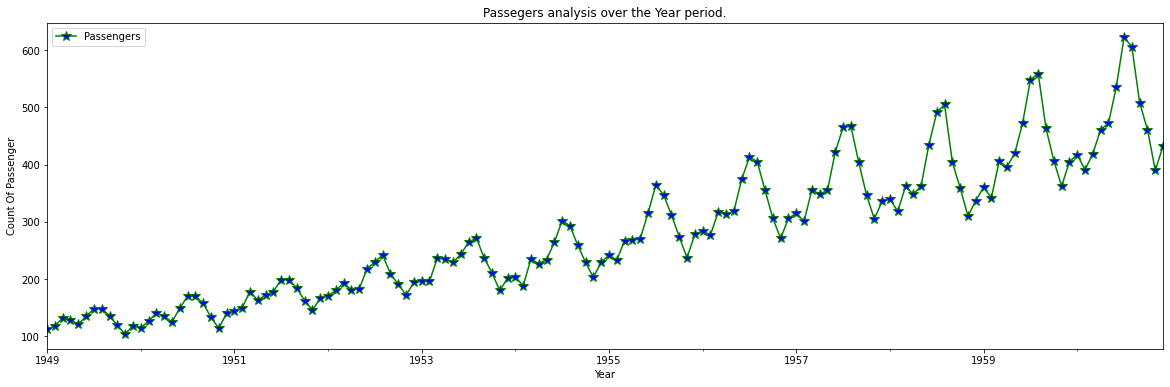

In [176]:
dataPassenger.plot(kind='line',linestyle='-',marker='*',color = 'g',figsize=(20,6), markerfacecolor='blue',markersize=10,title='Passegers analysis over the Year period.')
plt.xlabel('Year')
plt.ylabel('Count Of Passenger')
plt.show()

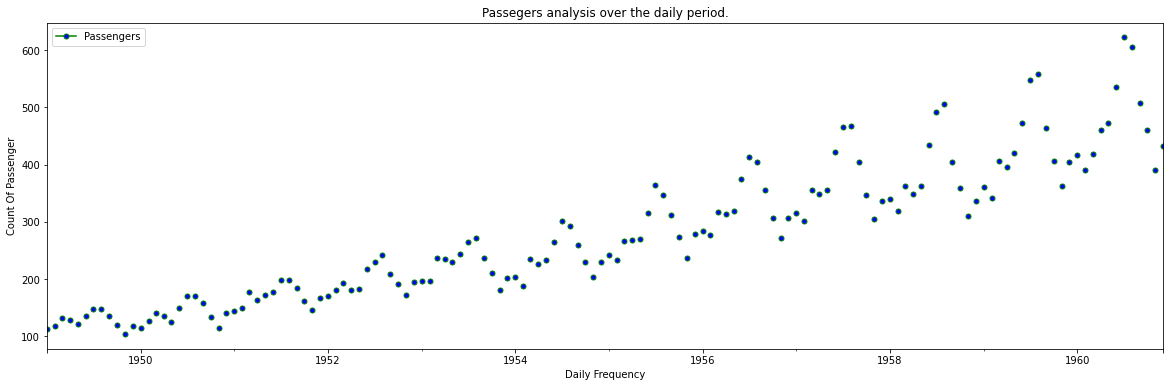

In [177]:
dailywise_data = dataPassenger.asfreq('D')
dailywise_data.plot(kind='line',marker='o',color = 'g',figsize=(20,6), markerfacecolor='blue',markersize=5,title='Passegers analysis over the daily period.')
plt.xlabel('Daily Frequency')
plt.ylabel('Count Of Passenger')
plt.show()

From the we can understand there is seasonality as well as trend avalible.It is not stationary series and Its Variance and mean is getting increase as we go ahead.

As we know the the neural network good in range 0 to 1 so we will use the MinMaxScaler in order to get the data in unique scale.

In [178]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataPassenger)

In [179]:
dataset[:5]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]])

### Now,we will split data for the training and testing.

We will how much data we will use for training and testing.

In [180]:
dataset.shape

(144, 1)

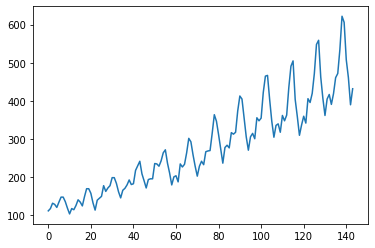

In [181]:
dataPassenger.reset_index()['Passengers'].plot()

Now we will select training upto the 100 days and for testing we use remaining days.

In [182]:
print('% of the data for training :-',100/100+44)
print('% of the data for testing:-',44/100+44)

% of the data for training :- 45.0
% of the data for testing:- 44.44


In [183]:
training_data = dataset[:100,:]
testing_data = dataset[100:,:]

In [184]:
training_data.shape,testing_data.shape

((100, 1), (44, 1))

## Build Testing And Training Dataset.

We reaquired previous input to get the present output of any time series problem.Here is the same thing happening.SO we iterating the series by its **length-1**

In [185]:
def get_data(dataset,look_back):
  dataX,dataY=[],[]
  for i in range(len(dataset)-look_back-1):
  #here I am taking the range of dataset from -1 that means we going to predict the output of the data on the 
  #basis of previous input.
  #look back it is just variable to determine how many days you want to look back and by default it is taking from (len of data-look_back)
  #I use -1 because i will use +1 for upcoming code so index wont be exceed.
    a = dataset[i:(i+look_back),0] #here I am getting data for training .Here slicing is done to on the it is taking whole data.

    dataX.append(a)
    dataY.append(dataset[i+look_back,0])  # it is start to iterate itself from i+lookback form. it means it is future data or we can say very next value.
  return np.array(dataX),np.array(dataY)

In [186]:
look_back =1
X_train,Y_train = get_data(training_data,look_back)

In [187]:
X_train.shape

(98, 1)

In [188]:
Y_train.shape

(98,)

If we see the value of the train data is getting decreases by shape.

In [189]:
X_train[:5]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]])

In [190]:
Y_train[:5]

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556])

If we see correctly the Training is start from 0.01544402 and Y_train is starting from the [0.02702703.

Thats means the Y_train is moved by one whereas the X_training lagging by one.This is important to prediction in time series analysis.


## Similarly for the test data.

In [191]:
X_test,Y_test = get_data(testing_data,1)

### Reshape the X_train and X_test.

In [192]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [193]:
X_train.shape,X_test.shape

((98, 1, 1), (42, 1, 1))

In [194]:
X_train.shape[0],X_train.shape[1],X_train.shape[2]

(98, 1, 1)

## Build The Model.

In [201]:
model = Sequential()
model.add(LSTM(10,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2]))) #X_train.shape[2]=look_back
model.add(LSTM(8))
model.add(Dense(1))

In [202]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 10)             480       
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 608       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


In [203]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [204]:
history=model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test),batch_size=1)

Epoch 1/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0375 - val_loss: 0.2003
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.1500
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.1236
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0890
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0700
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0390
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0188
Epoch 8/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0099
Epoch 9/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0106
Epoch 10/50
98/98 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0109
Epoch 11/50
98/98 

In [205]:
history.history

{'loss': [0.037539757788181305,
  0.01799408532679081,
  0.015748197212815285,
  0.013901776634156704,
  0.01127420924603939,
  0.008065512403845787,
  0.00531093729659915,
  0.003343653865158558,
  0.0026674075052142143,
  0.002428610809147358,
  0.0024001982528716326,
  0.002416469156742096,
  0.0023775578010827303,
  0.0023719295859336853,
  0.0023179410491138697,
  0.002417221898213029,
  0.0023205503821372986,
  0.002268187701702118,
  0.002369474619626999,
  0.002322067506611347,
  0.0023573460057377815,
  0.0024416951928287745,
  0.0022718366235494614,
  0.0023028566502034664,
  0.002218215959146619,
  0.0023626091424375772,
  0.0021758833900094032,
  0.002335516270250082,
  0.0023326915688812733,
  0.0022485244553536177,
  0.002465984085574746,
  0.002395507413893938,
  0.0022671024780720472,
  0.0022643841803073883,
  0.002312598517164588,
  0.0022684496361762285,
  0.002295777900144458,
  0.0022589843720197678,
  0.0023145866580307484,
  0.0021051911171525717,
  0.00218932610

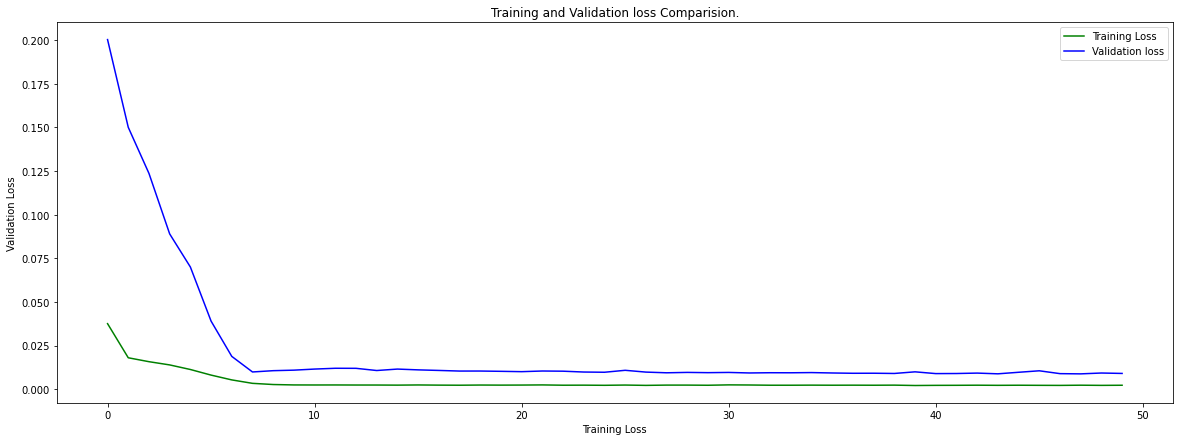

In [206]:
plt.figure(figsize=(20,7))
plt.plot(history.history['loss'],color='g')
plt.plot(history.history['val_loss'],color='b')
plt.xlabel('Training Loss')
plt.ylabel('Validation Loss')
plt.legend(['Training Loss','Validation loss'])
plt.title('Training and Validation loss Comparision.')
plt.show()

In [207]:
y_pred = model.predict(X_test)

In [208]:
scaler.scale_

array([0.0019305])

In [209]:
y_test = Y_test.reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
y_test

array([[422.],
       [465.],
       [467.],
       [404.],
       [347.],
       [305.],
       [336.],
       [340.],
       [318.],
       [362.],
       [348.],
       [363.],
       [435.],
       [491.],
       [505.],
       [404.],
       [359.],
       [310.],
       [337.],
       [360.],
       [342.],
       [406.],
       [396.],
       [420.],
       [472.],
       [548.],
       [559.],
       [463.],
       [407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.]])

In [210]:
y_pred = scaler.inverse_transform(y_pred)
y_pred

array([[350.84637],
       [414.02676],
       [452.97354],
       [454.74808],
       [397.3134 ],
       [343.1538 ],
       [302.47678],
       [332.541  ],
       [336.40454],
       [315.1052 ],
       [357.55685],
       [344.11664],
       [358.51385],
       [425.9546 ],
       [475.76437],
       [487.77814],
       [397.3134 ],
       [354.6834 ],
       [307.3363 ],
       [333.50732],
       [355.64166],
       [338.3345 ],
       [399.18115],
       [389.81717],
       [412.18076],
       [459.16907],
       [523.47784],
       [532.3091 ],
       [451.19556],
       [400.11407],
       [357.55685],
       [398.24762],
       [409.40643],
       [385.1122 ],
       [411.25668],
       [449.41415],
       [459.16907],
       [512.88055],
       [580.4374 ],
       [568.6135 ],
       [490.3282 ],
       [449.41415]], dtype=float32)

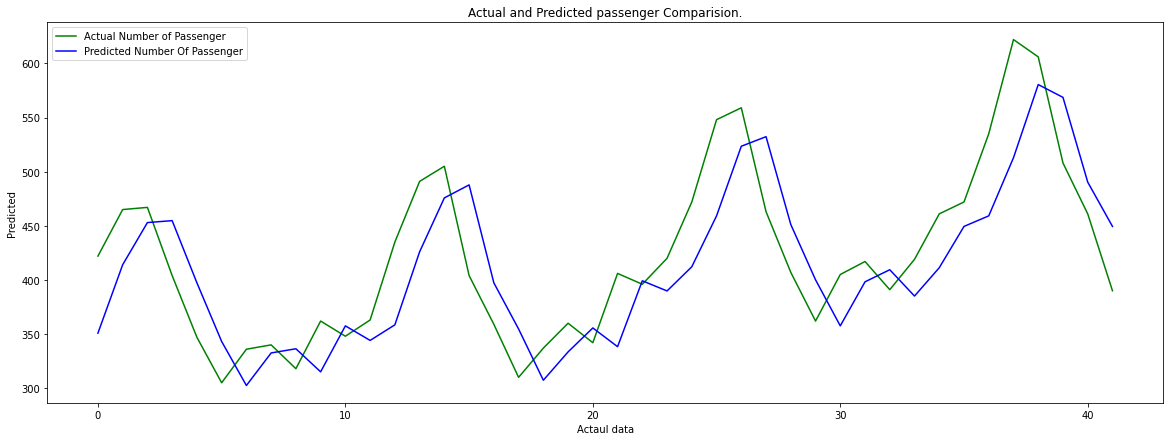

In [211]:
plt.figure(figsize=(20,7))
plt.plot(y_test,color='g')
plt.plot(y_pred,color='b')
plt.xlabel('Actaul data')
plt.ylabel('Predicted')
plt.legend(['Actual Number of Passenger','Predicted Number Of Passenger'])
plt.title('Actual and Predicted passenger Comparision.')
plt.show()

## Understand It is good model or not.

In [213]:
val_score = model.evaluate(X_test,Y_test,batch_size=1)

42/42 [==============================] - 0s 2ms/step - loss: 0.0090


### Error induce due to to modeling.

In [214]:
MSE = mean_squared_error(y_test,y_pred)
MSE

2420.5300376513264

In [215]:
error = np.sqrt(MSE)
error

49.19888248376508

## Error already avalible inside the data.By comapring dispursion of data from the mean,That is called as Standard deviation.

In [216]:
self_error = np.std(y_test)
self_error

77.54904819069958

If we compare the self error of the data is greater than the error induced by the modeling.Since from loss comparision graph and from our recent assumption we can conclude that this model is good model.

## Thank You !!